In [2]:
# Modified imports with different arrangement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import pymysql
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as stats
import warnings
import os
import logging
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple, Optional, Any
from dotenv import load_dotenv

# Suppress warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('Data Pipelining, Analysis and Visualization')

In [3]:
class DataPipelineManager:
    """
    A class to manage data pipelines, handle MySQL database connections,
    and provide methods for data manipulation and storage.
    """
    
    def __init__(self, host: str = "127.0.0.1", user: str = "root", 
                 password: str = "", database: str = "data_analytics",
                 port: int = 3306):
        """
        Initialize the DataPipelineManager with a MySQL database connection.
        
        Args:
            host: MySQL server hostname
            user: MySQL username
            password: MySQL password
            database: MySQL database name
            port: MySQL server port
        """
        self.connection_params = {
            'host': host,
            'user': user,
            'password': password,
            'database': database,
            'port': port
        }
        self.logger = logger
        self.conn = self._create_connection()
        self.logger.info(f"Initialized DataPipelineManager with MySQL database at {host}:{port}/{database}")
    
    def _create_connection(self) -> pymysql.connections.Connection:
        """Create and return a MySQL database connection."""
        try:
            # Try to connect to the database
            conn = pymysql.connect(**self.connection_params)
            return conn
        except pymysql.err.OperationalError as e:
            error_code = e.args[0]
            # Check if the error is due to missing database (error code 1049)
            if error_code == 1049:  # Unknown database
                try:
                    # Connect without specifying database
                    temp_params = self.connection_params.copy()
                    database_name = temp_params.pop('database')
                    temp_conn = pymysql.connect(**temp_params)
                    
                    # Create the database
                    cursor = temp_conn.cursor()
                    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
                    cursor.close()
                    temp_conn.close()
                    
                    # Try connecting again
                    return pymysql.connect(**self.connection_params)
                except pymysql.Error as create_error:
                    raise ConnectionError(f"Failed to create database: {create_error}")
            else:
                raise ConnectionError(f"Database connection error: {e}")
    
    def _clean_data(self, data: List[Dict[str, Any]], columns: List[str]) -> List[Tuple]:
        """
        Clean and prepare data for database insertion.
        
        Args:
            data: List of dictionaries containing data
            columns: List of column names to extract from data
            
        Returns:
            List of tuples ready for database insertion
        """
        cleaned_data = []
        for row in data:
            # Extract only the specified columns
            cleaned_row = tuple(row.get(col, '') for col in columns)
            cleaned_data.append(cleaned_row)
        
        self.logger.info(f"Cleaned {len(cleaned_data)} rows of data")
        return cleaned_data
    
    def is_connected(self):
        """Check if the connection is active."""
        try:
            self.conn.ping(reconnect=False)
            return True
        except:
            return False
    
    def save_data(self, table_name: str, columns: List[str], data: List[Dict[str, Any]]) -> bool:
        """
        Save data to a MySQL database table. Create the table if it doesn't exist.
        
        Args:
            table_name: Name of the table to save data to
            columns: List of column names
            data: List of dictionaries containing data
            
        Returns:
            Boolean indicating success
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
            
            cursor = self.conn.cursor()
            
            # Create table if it doesn't exist
            columns_with_types = [f"`{col}` VARCHAR(255)" for col in columns]
            create_table_query = f"""
            CREATE TABLE IF NOT EXISTS `{table_name}` (
                `id` INT AUTO_INCREMENT PRIMARY KEY,
                {', '.join(columns_with_types)},
                `created_at` TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
            """
            cursor.execute(create_table_query)
            
            # Clean and prepare data
            cleaned_data = self._clean_data(data, columns)
            
            # Insert data into table
            placeholders = ', '.join(['%s' for _ in columns])
            insert_query = f"""
            INSERT INTO `{table_name}` (`{'`, `'.join(columns)}`)
            VALUES ({placeholders})
            """
            
            cursor.executemany(insert_query, cleaned_data)
            self.conn.commit()
            
            self.logger.info(f"Successfully saved {len(cleaned_data)} rows to table '{table_name}'")
            cursor.close()
            return True
            
        except Exception as e:
            self.conn.rollback()
            self.logger.error(f"Error saving data to table '{table_name}': {e}")
            return False
    
    def get_data(self, 
                table_name: str, 
                columns: Optional[List[str]] = None, 
                limit: Optional[int] = None,
                where_clause: Optional[str] = None,
                order_by: Optional[str] = None) -> pd.DataFrame:
        """
        Query data from a specified table.
        
        Args:
            table_name: Name of the table to query
            columns: List of columns to retrieve (None for all columns)
            limit: Maximum number of rows to return
            where_clause: SQL WHERE condition
            order_by: SQL ORDER BY clause
            
        Returns:
            DataFrame containing the query results
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
            
            # Build the SELECT part of the query
            cols_str = "*" if columns is None else "`" + "`, `".join(columns) + "`"
            query = f"SELECT {cols_str} FROM `{table_name}`"
            
            # Add WHERE clause if specified
            if where_clause:
                query += f" WHERE {where_clause}"
                
            # Add ORDER BY clause if specified
            if order_by:
                query += f" ORDER BY {order_by}"
                
            # Add LIMIT clause if specified
            if limit is not None:
                query += f" LIMIT {limit}"
            
            # Execute query using pandas
            df = pd.read_sql(query, self.conn)
            self.logger.info(f"Retrieved {len(df)} rows from table '{table_name}'")
            return df
            
        except Exception as e:
            self.logger.error(f"Error retrieving data from table '{table_name}': {e}")
            return pd.DataFrame()
    
    def execute_query(self, query: str, params: tuple = ()) -> pd.DataFrame:
        """
        Execute a custom SQL query.
        
        Args:
            query: SQL query to execute
            params: Parameters for the query
            
        Returns:
            DataFrame containing the query results
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            # Execute query using pandas
            df = pd.read_sql(query, self.conn, params=params)
            self.logger.info(f"Custom query executed successfully, returned {len(df)} rows")
            return df
        except Exception as e:
            self.logger.error(f"Error executing custom query: {e}")
            return pd.DataFrame()
    
    def get_table_schema(self, table_name: str) -> pd.DataFrame:
        """
        Get the schema information for a table.
        
        Args:
            table_name: Name of the table
            
        Returns:
            DataFrame containing the table schema
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            query = f"DESCRIBE `{table_name}`"
            df = pd.read_sql(query, self.conn)
            return df
        except Exception as e:
            self.logger.error(f"Error retrieving schema for table '{table_name}': {e}")
            return pd.DataFrame()
    
    def list_tables(self) -> List[str]:
        """
        Get a list of all tables in the database.
        
        Returns:
            List of table names
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            cursor = self.conn.cursor()
            cursor.execute("SHOW TABLES")
            tables = [row[0] for row in cursor.fetchall()]
            cursor.close()
            return tables
        except Exception as e:
            self.logger.error(f"Error listing tables: {e}")
            return []
    
    def create_index(self, table_name: str, columns: List[str], index_name: Optional[str] = None) -> bool:
        """
        Create an index on specified columns.
        
        Args:
            table_name: Name of the table
            columns: List of columns to include in the index
            index_name: Name of the index (optional)
            
        Returns:
            Boolean indicating success
        """
        if not index_name:
            index_name = f"idx_{table_name}_{'_'.join(columns)}"
            
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            cursor = self.conn.cursor()
            query = f"CREATE INDEX `{index_name}` ON `{table_name}` (`{'`, `'.join(columns)}`)"
            cursor.execute(query)
            self.conn.commit()
            cursor.close()
            self.logger.info(f"Created index '{index_name}' on table '{table_name}'")
            return True
        except Exception as e:
            self.conn.rollback()
            self.logger.error(f"Error creating index: {e}")
            return False
    
    def perform_data_transformation(self, df: pd.DataFrame, transformations: Dict[str, callable]) -> pd.DataFrame:
        """
        Apply a series of transformations to a DataFrame.
        
        Args:
            df: Input DataFrame
            transformations: Dictionary mapping column names to transformation functions
            
        Returns:
            Transformed DataFrame
        """
        transformed_df = df.copy()
        
        for column, transform_func in transformations.items():
            if column in transformed_df.columns:
                transformed_df[column] = transformed_df[column].apply(transform_func)
                
        return transformed_df
    
    def execute_transaction(self, queries: List[Tuple[str, tuple]]) -> bool:
        """
        Execute multiple queries as a single transaction.
        
        Args:
            queries: List of (query, params) tuples
            
        Returns:
            Boolean indicating success
        """
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            cursor = self.conn.cursor()
            for query, params in queries:
                cursor.execute(query, params)
            self.conn.commit()
            cursor.close()
            self.logger.info(f"Transaction with {len(queries)} queries executed successfully")
            return True
        except Exception as e:
            self.conn.rollback()
            self.logger.error(f"Transaction failed: {e}")
            return False
    
    def backup_table(self, table_name: str, backup_suffix: str = "_backup") -> bool:
        """
        Create a backup of a table.
        
        Args:
            table_name: Name of the table to backup
            backup_suffix: Suffix to append to the original table name
            
        Returns:
            Boolean indicating success
        """
        backup_table = f"{table_name}{backup_suffix}"
        try:
            # Reconnect if connection is closed
            if not self.is_connected():
                self.conn = self._create_connection()
                
            cursor = self.conn.cursor()
            
            # Drop the backup table if it exists
            cursor.execute(f"DROP TABLE IF EXISTS `{backup_table}`")
            
            # Create the backup table
            cursor.execute(f"CREATE TABLE `{backup_table}` LIKE `{table_name}`")
            cursor.execute(f"INSERT INTO `{backup_table}` SELECT * FROM `{table_name}`")
            self.conn.commit()
            cursor.close()
            self.logger.info(f"Created backup of table '{table_name}' as '{backup_table}'")
            return True
        except Exception as e:
            self.conn.rollback()
            self.logger.error(f"Error backing up table: {e}")
            return False
    
    def close(self):
        """Close the database connection."""
        if self.conn:
            self.conn.close()
            self.logger.info("Database connection closed")

In [4]:
# load database credentials
load_dotenv()

HOST=os.getenv("HOST")
USER=os.getenv("USER")
PASSWORD=os.getenv("PASSWORD")
DATABASE=os.getenv("DATABASE")
PORT=os.getenv("PORT")

db = DataPipelineManager(host=HOST, user=USER, password=PASSWORD, database=DATABASE, port=int(PORT))

2025-04-27 11:37:43,558 - Data Pipelining, Analysis and Visualization - INFO - Initialized DataPipelineManager with MySQL database at 127.0.0.1:3306/data_analytics


In [5]:
def retrieve_csv_data() -> dict:
    """
    Locate and load CSV files from the 'datasets' directory
    Returns: Dictionary with dataset names as keys and DataFrames as values
    """
    dataset_collection = {}
    
    # Navigate directory structure
    current_dir = os.getcwd()
    # upper_dir = os.path.dirname(current_dir)
    data_folder = os.path.join(current_dir, 'datasets')

    
    # Find all CSV files
    csv_file_paths = []
    for file in os.listdir(data_folder):
        if file.endswith('.csv'):
            csv_file_paths.append(f"datasets/{file}")
    
    # Process each dataset
    for idx, filepath in enumerate(csv_file_paths):
        file_data = pd.read_csv(os.path.join(os.getcwd(), filepath))
        file_name = filepath.split("/")[1].split(".")[0]
        print(f"{idx+1}: {file_name}")
        dataset_collection[file_name] = file_data
    
    return dataset_collection

In [6]:
def prepare_dataset(data: pd.DataFrame, target_col: str, excluded_patterns: list=None) -> pd.DataFrame:
    """
    Prepare dataset for analysis by removing unwanted columns, duplicates,
    and handling missing values
    
    Args:
        data: Input DataFrame
        target_col: Target column name
        excluded_patterns: List of patterns to exclude in column names
        
    Returns: Cleaned DataFrame
    """
    if excluded_patterns is None:
        excluded_patterns = []
    
    # Remove columns matching exclusion patterns
    filtered_df = data.drop([col for col in data.columns if any(pattern in col for pattern in excluded_patterns)], axis=1)
    
    # Remove duplicate rows
    filtered_df = filtered_df.loc[~filtered_df.duplicated()]
    
    # Check for missing values
    missing_count = filtered_df.isnull().sum()
    if missing_count.sum() > 0:
        pass
        # print(missing_count)
        
    return filtered_df

In [7]:
# Load datasets into dictionary
data_dict = retrieve_csv_data()

# Define mapping of dataset keys to table names and prepare modes
table_configs = {
    "disease_symptom": ("Disease", list(data_dict.keys())[0]),
    "aids_trials": ("labels", list(data_dict.keys())[1])
}

# Process and save each dataset
for table_name, (prep_mode, data_key) in table_configs.items():
    df = prepare_dataset(data_dict[data_key], prep_mode)
    df = df.where(pd.notnull(df), None)
    
    db.save_data(
        table_name=table_name,
        columns=df.columns,
        data=df.to_dict(orient="records")
    )


2025-04-27 11:37:43,645 - Data Pipelining, Analysis and Visualization - INFO - Cleaned 304 rows of data
2025-04-27 11:37:43,664 - Data Pipelining, Analysis and Visualization - INFO - Successfully saved 304 rows to table 'disease_symptom'
2025-04-27 11:37:43,695 - Data Pipelining, Analysis and Visualization - INFO - Cleaned 2139 rows of data
2025-04-27 11:37:43,749 - Data Pipelining, Analysis and Visualization - INFO - Successfully saved 2139 rows to table 'aids_trials'


1: disease_and_symptoms
2: aids_trials


In [20]:
#read data from db 
disease_symptom = db.get_data("disease_symptom")
aids_trials = db.get_data("aids_trials")

2025-04-27 11:45:15,577 - Data Pipelining, Analysis and Visualization - INFO - Retrieved 2128 rows from table 'disease_symptom'
2025-04-27 11:45:15,839 - Data Pipelining, Analysis and Visualization - INFO - Retrieved 14973 rows from table 'aids_trials'


## Disease symptom analysis

In [21]:
# Clean and prepare first dataset
df = prepare_dataset(data=disease_symptom, target_col='Disease', excluded_patterns=['Unnamed'])
df = df.replace('', np.nan)

# Counting the frequency of different diseases
disease_counts = df['Disease'].value_counts().reset_index()
disease_counts.columns = ['Disease', 'Count']

# Counting the occurrence of each symptom
all_symptoms = []
for col in df.columns[1:]:  # Skip the Disease column
    symptoms = df[col].dropna()
    all_symptoms.extend(symptoms.tolist())

symptom_counts = pd.Series(all_symptoms).value_counts().reset_index()
symptom_counts.columns = ['Symptom', 'Count']

# Create a new DataFrame for symptom presence in each disease
symptom_presence = pd.DataFrame()
for disease in df['Disease'].unique():
    disease_data = df[df['Disease'] == disease]
    all_symptoms_in_disease = []
    for col in df.columns[1:]:
        symptoms = disease_data[col].dropna()
        all_symptoms_in_disease.extend(symptoms.tolist())
    
    symptom_counts_for_disease = pd.Series(all_symptoms_in_disease).value_counts()
    symptom_presence[disease] = pd.Series(symptom_counts_for_disease)

symptom_presence = symptom_presence.fillna(0)

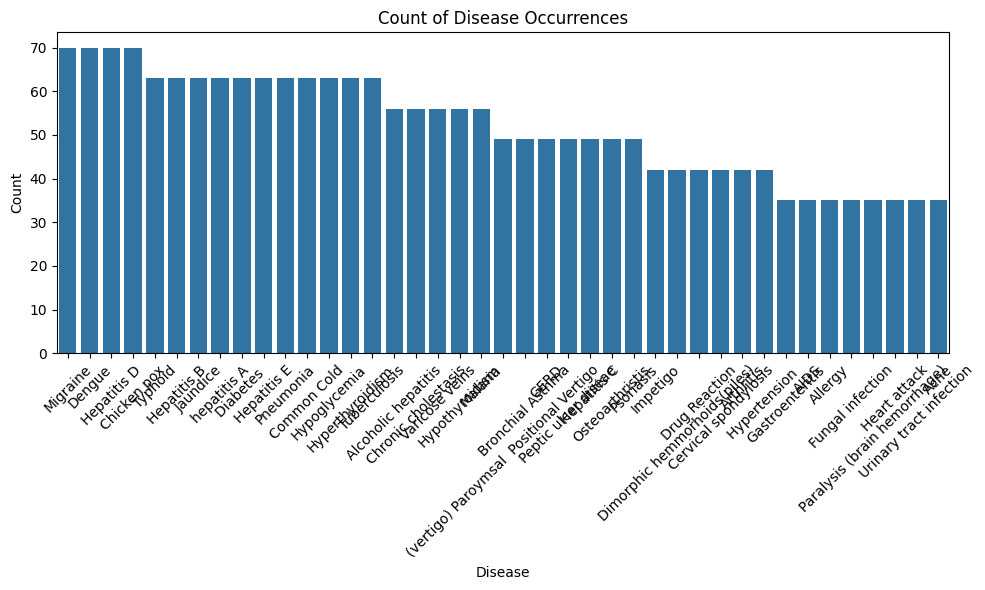

In [22]:
# 1. Bar Chart: Disease Counts
plt.figure(figsize=(10, 6))
sns.barplot(x='Disease', y='Count', data=disease_counts)
plt.title('Count of Disease Occurrences')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./visualizations/disease_counts.png')
plt.show()
plt.close()

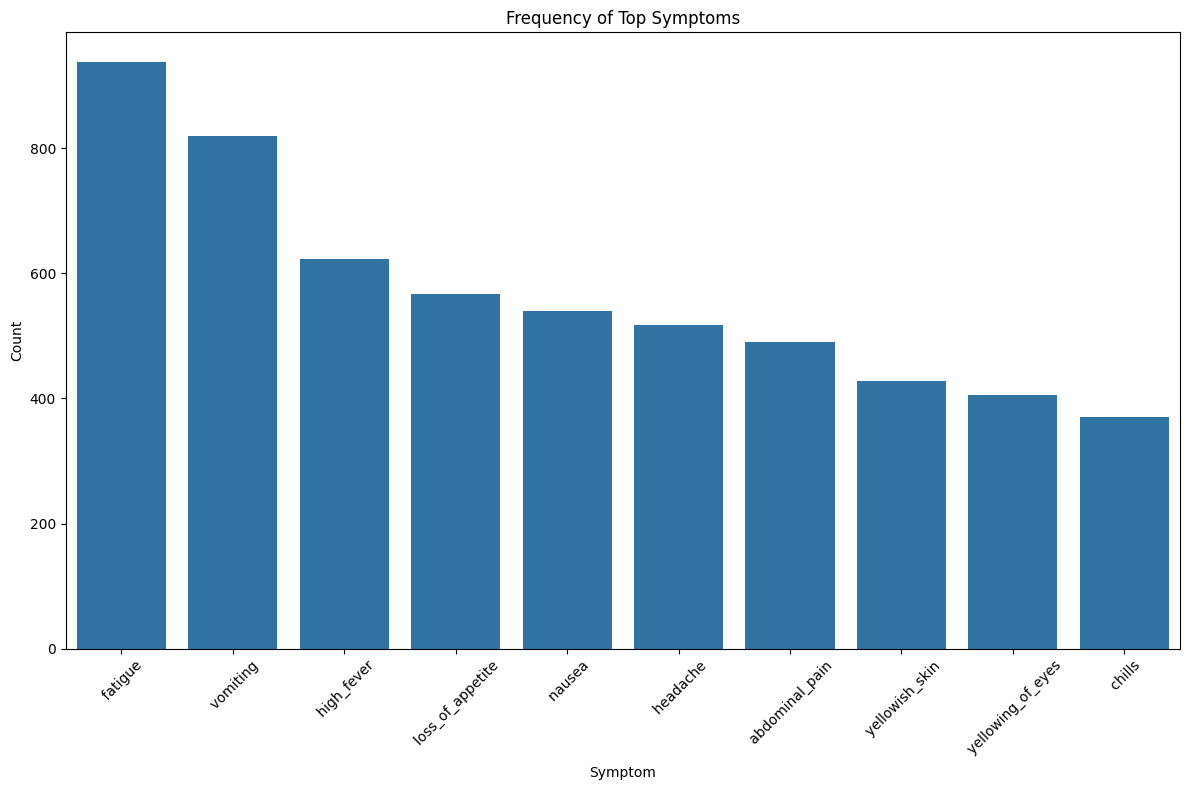

In [23]:
# 2. Bar Chart: Symptom Frequency
plt.figure(figsize=(12, 8))
sns.barplot(x='Symptom', y='Count', data=symptom_counts.head(10))  # Top 10 symptoms
plt.title('Frequency of Top Symptoms')
plt.xlabel('Symptom')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./visualizations/symptom_frequency.png')
plt.show()
plt.close()

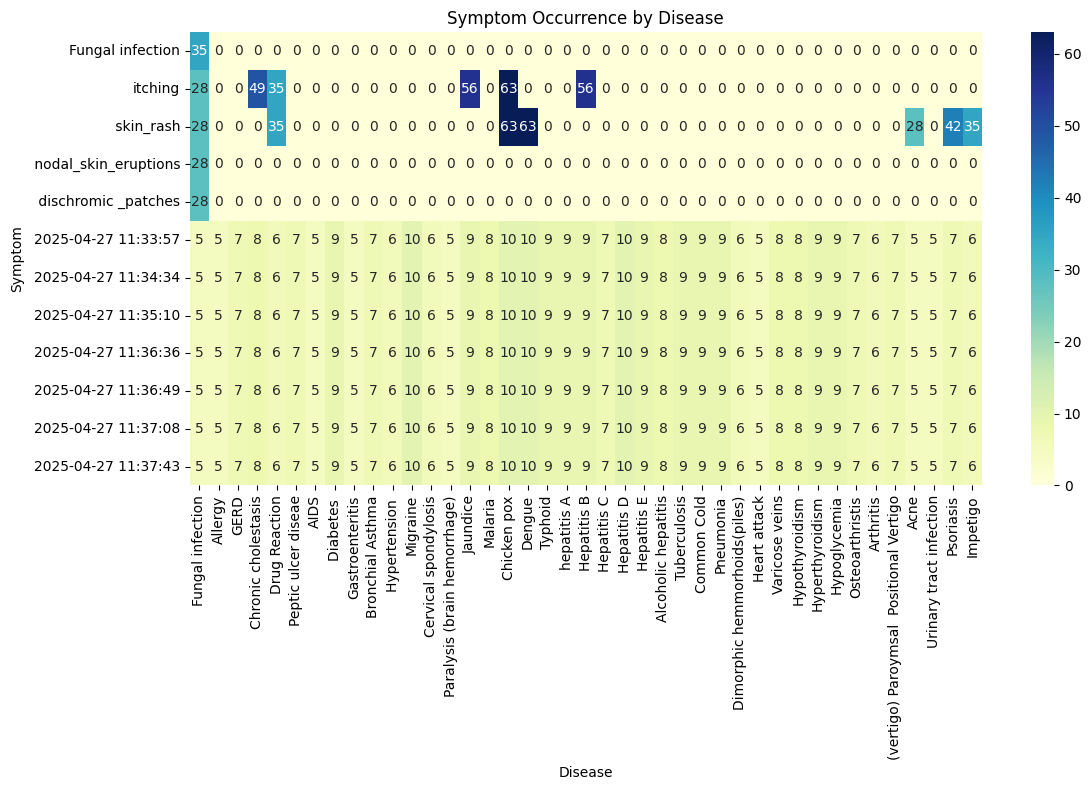

In [24]:
# 3. Heatmap: Symptom by Disease
plt.figure(figsize=(12, 8))
sns.heatmap(symptom_presence, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Symptom Occurrence by Disease')
plt.xlabel('Disease')
plt.ylabel('Symptom')
plt.tight_layout()
plt.savefig('./visualizations/symptom_disease_heatmap.png')
plt.show()
plt.close()

<Figure size 1400x800 with 0 Axes>

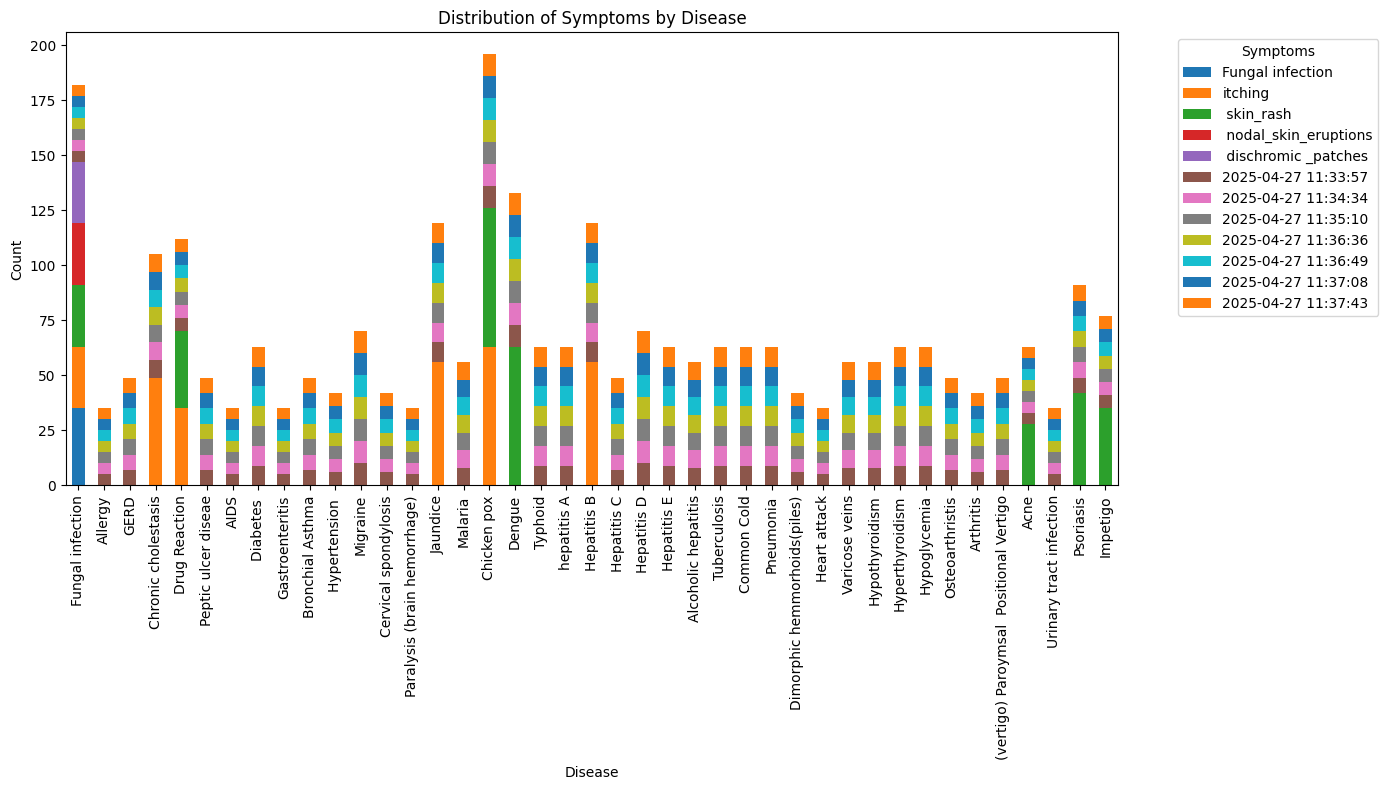

In [25]:
# 4. Stacked Bar Chart: Symptoms Distribution in Diseases
# Preparing data for stacked bar
stacked_data = pd.DataFrame()
for disease in df['Disease'].unique():
    disease_data = df[df['Disease'] == disease]
    symptom_counts = {}
    
    for col in df.columns[1:]:
        symptoms = disease_data[col].dropna()
        for symptom in symptoms:
            if symptom in symptom_counts:
                symptom_counts[symptom] += 1
            else:
                symptom_counts[symptom] = 1
    
    stacked_data[disease] = pd.Series(symptom_counts)

stacked_data = stacked_data.fillna(0).T  # Transpose for better visualization

plt.figure(figsize=(14, 8))
stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Symptoms by Disease')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.legend(title='Symptoms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./visualizations/symptom_distribution.png')
plt.show()
plt.close()

## AIDS Trial analysis dataset

In [26]:
df = prepare_dataset(data=aids_trials, target_col='label')
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

<Figure size 1400x800 with 0 Axes>

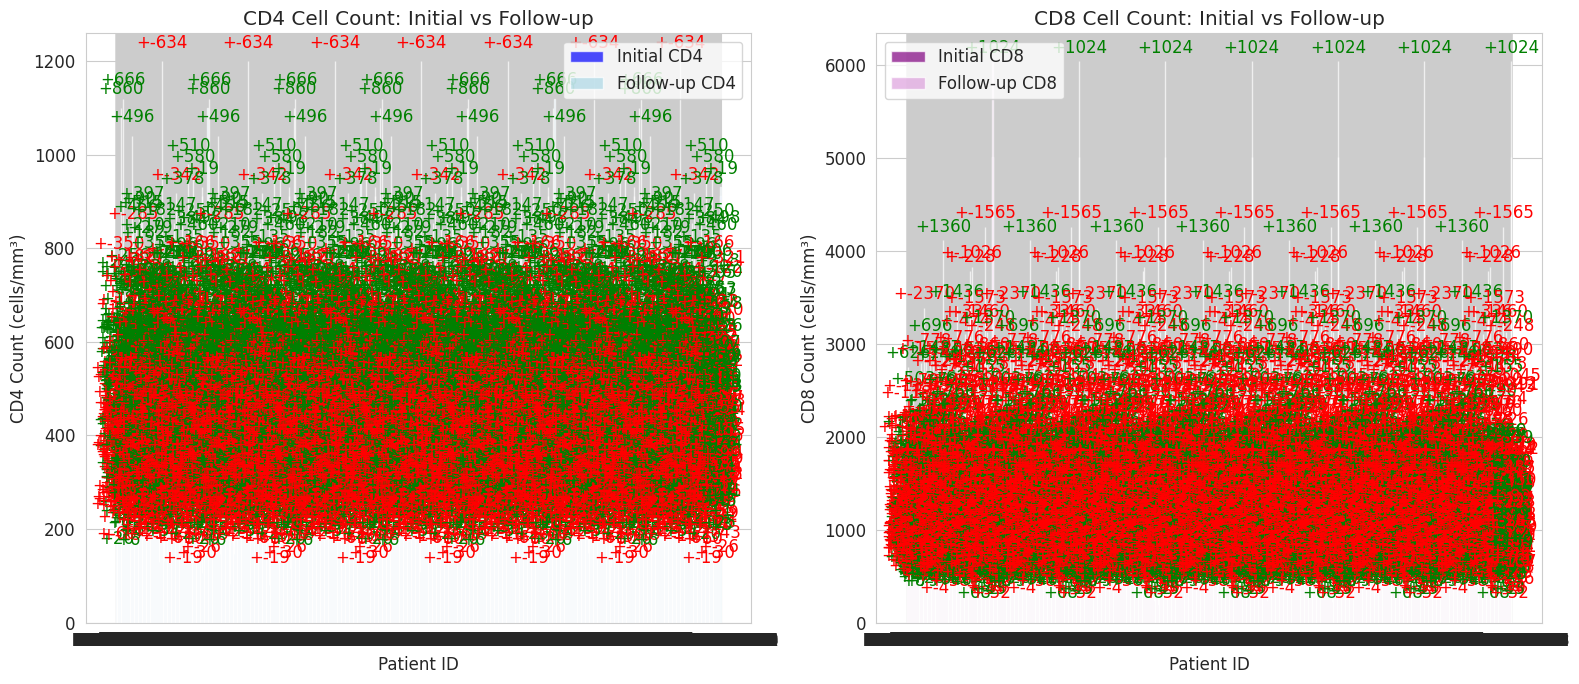

In [28]:
# Ensure relevant columns are numeric
df['cd40'] = pd.to_numeric(df['cd40'], errors='coerce')
df['cd420'] = pd.to_numeric(df['cd420'], errors='coerce')
df['cd80'] = pd.to_numeric(df['cd80'], errors='coerce')
df['cd820'] = pd.to_numeric(df['cd820'], errors='coerce')

# Visualization 1: CD4 and CD8 Counts Comparison
plt.figure(figsize=(14, 8))

# Create a subplot grid
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Initial and follow-up CD4 counts
axes[0].bar(df.index, df['cd40'], color='blue', alpha=0.7, label='Initial CD4')
axes[0].bar(df.index, df['cd420'], color='lightblue', alpha=0.7, label='Follow-up CD4', bottom=0)
for i, (cd40, cd420) in enumerate(zip(df['cd40'], df['cd420'])):
    if pd.notnull(cd40) and pd.notnull(cd420):  # Check if both values are not NaN
        axes[0].annotate(f"+{cd420-cd40:.0f}", xy=(i, max(cd40, cd420) + 20),
                         ha='center', va='bottom', color='green' if cd420 > cd40 else 'red')
axes[0].set_title('CD4 Cell Count: Initial vs Follow-up')
axes[0].set_ylabel('CD4 Count (cells/mm³)')
axes[0].set_xlabel('Patient ID')
axes[0].set_xticks(df.index)
axes[0].set_xticklabels([f"Patient {i+1}" for i in range(len(df))])
axes[0].legend()

# Initial and follow-up CD8 counts
axes[1].bar(df.index, df['cd80'], color='purple', alpha=0.7, label='Initial CD8')
axes[1].bar(df.index, df['cd820'], color='plum', alpha=0.7, label='Follow-up CD8', bottom=0)
for i, (cd80, cd820) in enumerate(zip(df['cd80'], df['cd820'])):
    if pd.notnull(cd80) and pd.notnull(cd820):  # Check if both values are not NaN
        axes[1].annotate(f"+{cd820-cd80:.0f}", xy=(i, max(cd80, cd820) + 50),
                         ha='center', va='bottom', color='green' if cd820 > cd80 else 'red')
axes[1].set_title('CD8 Cell Count: Initial vs Follow-up')
axes[1].set_ylabel('CD8 Count (cells/mm³)')
axes[1].set_xlabel('Patient ID')
axes[1].set_xticks(df.index)
axes[1].set_xticklabels([f"Patient {i+1}" for i in range(len(df))])
axes[1].legend()

plt.tight_layout()
plt.savefig('./visualizations/cd_counts_comparison.png')
plt.show()
plt.close()


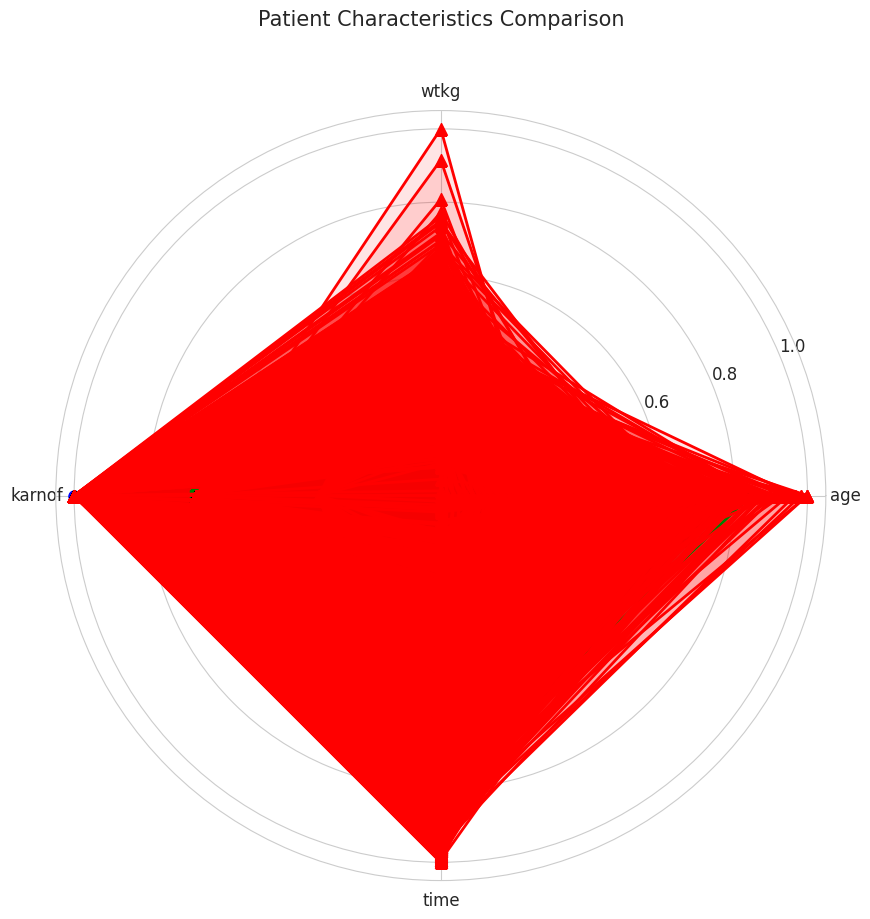

In [122]:
# Select relevant features for the radar chart
features = ['age', 'wtkg', 'karnof', 'time']

# Number of variables
N = len(features)

# Create normalized data for radar chart
normalized_data = pd.DataFrame()
for feature in features:
    min_val = df[feature].min()
    max_val = df[feature].max()
    normalized_data[feature] = (df[feature] - min_val) / (max_val - min_val)

# Compute angle for each feature
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the polygon

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define colors, markers, and labels
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']
labels = ['Patient 1 (Label 0)', 'Patient 2 (Label 1)', 'Patient 3 (Label 0)']

# Add patient data with unique colors and markers
for i in range(len(df)):
    values = normalized_data.iloc[i].values.tolist()
    # close the polygon by appending the first value
    values += [values[0]]
        
    # i is within range of colors, markers, and labels lists
    color_idx = min(i, len(colors)-1)
    marker_idx = min(i, len(markers)-1)
    label_idx = min(i, len(labels)-1)
    
    ax.plot(angles, values, color=colors[color_idx], linewidth=2, linestyle='solid', 
            marker=markers[marker_idx], markersize=8, label=labels[label_idx])
    ax.fill(angles, values, color=colors[color_idx], alpha=0.1)

# Set category labels with the last repeated one removed to match angles
plt.xticks(angles[:-1], features)

plt.title('Patient Characteristics Comparison', size=15, y=1.1)
plt.savefig('./visualizations/patient_characteristics_radar.png')
plt.show()

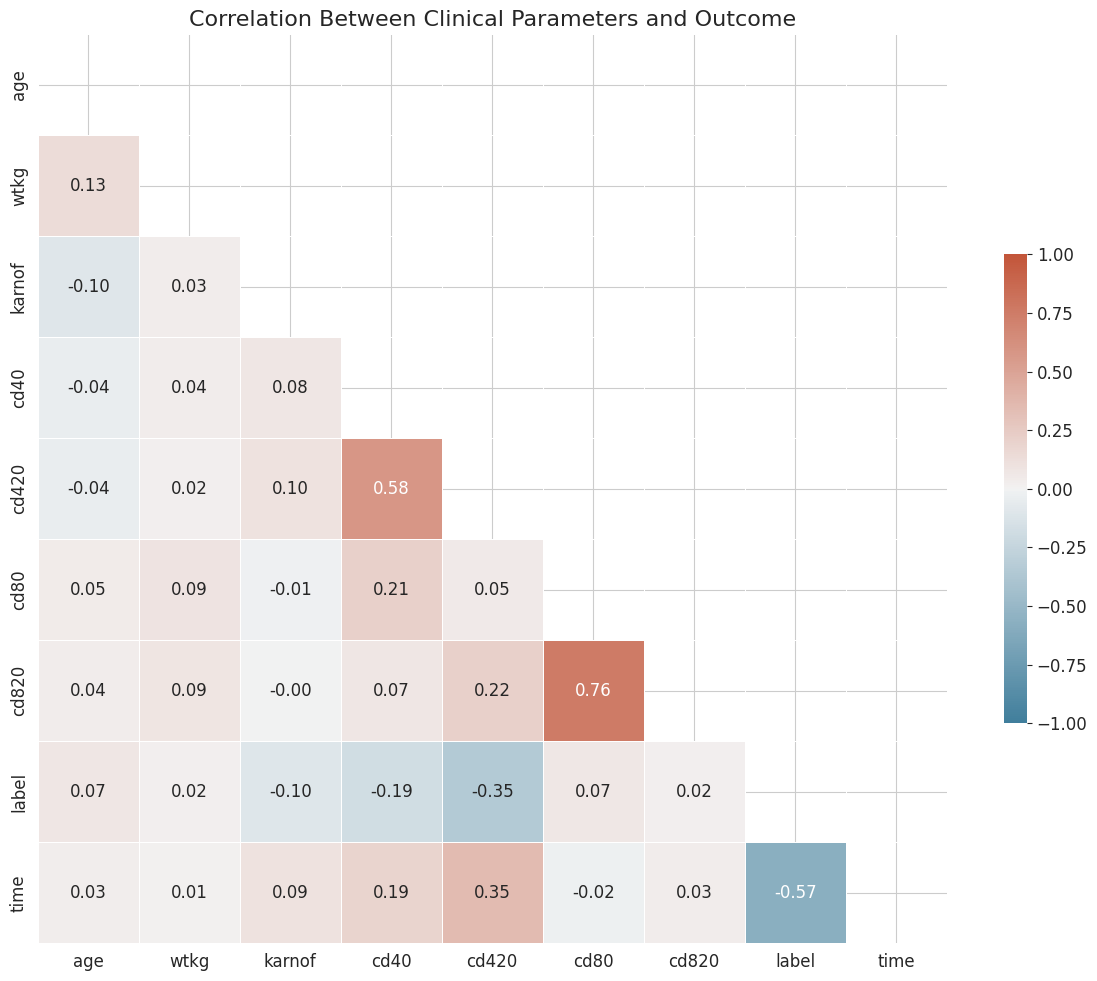

In [123]:
# Visualization 3: Correlation Heatmap with Patient Outcomes
# Select clinical parameters for correlation analysis
clinical_params = ['age', 'wtkg', 'karnof', 'cd40', 'cd420', 'cd80', 'cd820', 'label', 'time']
correlation_df = df[clinical_params].copy()

# Calculate correlation matrix
corr_matrix = correlation_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Between Clinical Parameters and Outcome', size=16)
plt.tight_layout()
plt.savefig('./visualizations/clinical_correlation_heatmap.png')
plt.show()
plt.close()